In [2]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Validating the GTFS stops and CIS data in directions

There are four heat maps outputted, which indicate the distributions of GTFS data and CIS data of each stop_sequence in hours in different directions.

In [59]:
sql_GTFS_1 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 1 AND (shape_id = 691040 OR shape_id = 691042)
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)
df1 = pandasql.read_sql(sql_GTFS_1, con)

df1 = df1.pivot("hours", "stop_sequence", "schedule")

In [61]:
sql_GTFS_0 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND (shape_id = 691040 OR shape_id = 691042)
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df2 = pandasql.read_sql(sql_GTFS_0, con)

df2 = df2.pivot("hours", "stop_sequence", "schedule")

In [64]:
sql_cis_1 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 1
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND (shape_id = 691040 OR shape_id = 691042)
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df3 = pandasql.read_sql(sql_cis_1, con)

df3 = df3.pivot("hours", "stop_sequence", "cis_data")

In [82]:
sql_cis_0 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 0
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND (shape_id = 691040 OR shape_id = 691042)
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df4 = pandasql.read_sql(sql_cis_0, con)

df4 = df4.pivot("hours", "stop_sequence", "cis_data")

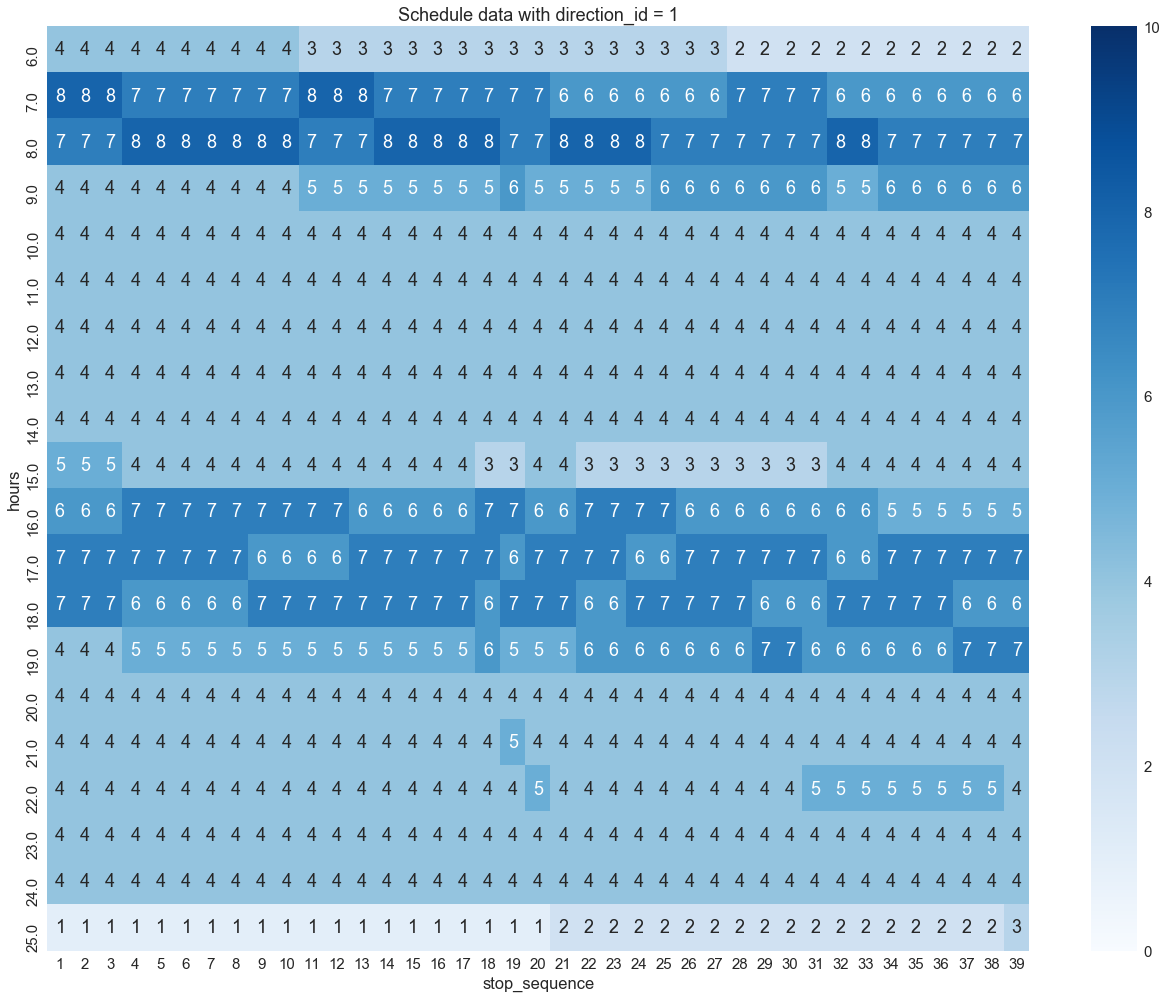

In [80]:
plt.figure(figsize = (22,17))
ax = plt.axes()
ax.set_title('Schedule data with direction_id = 1')
sns.heatmap(df1, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

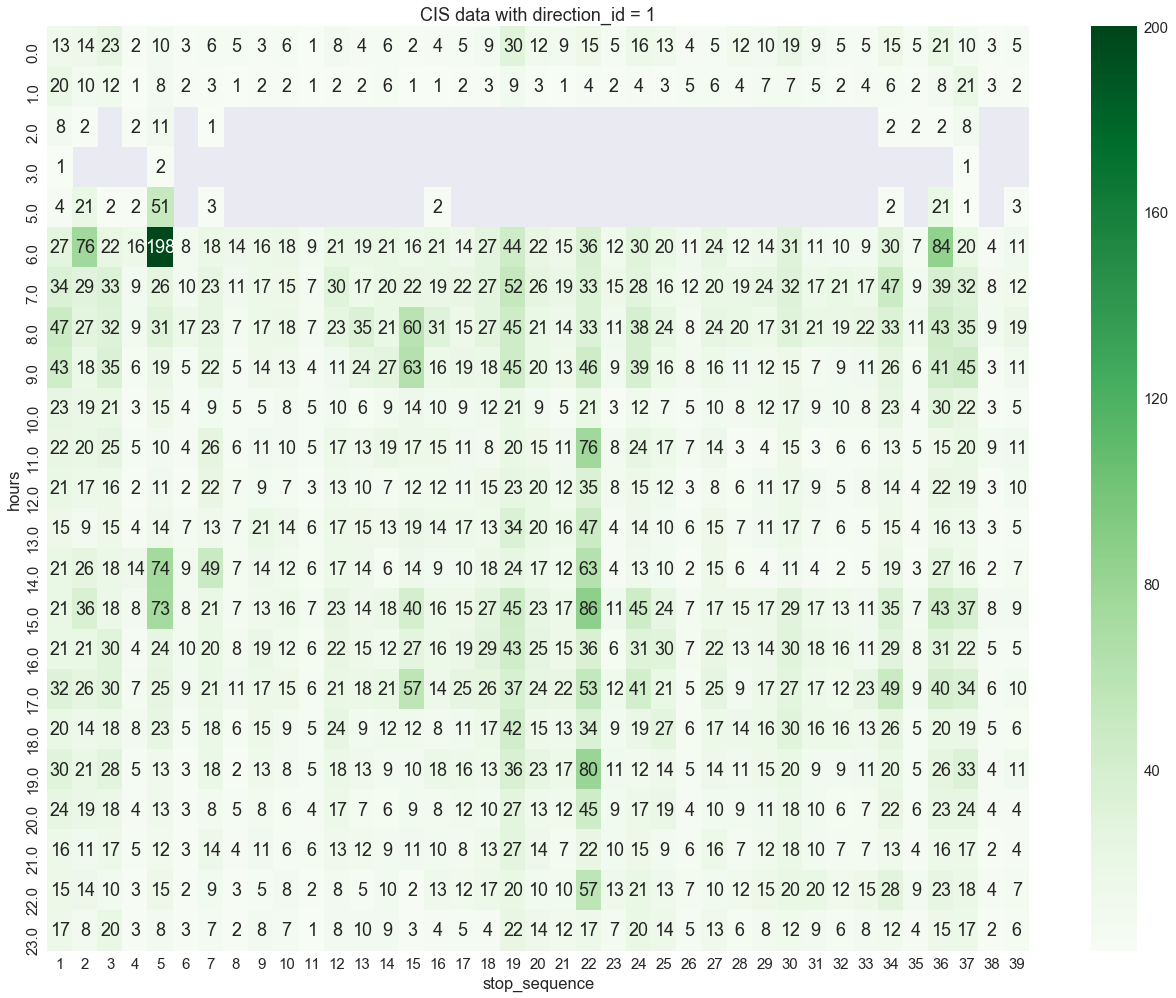

In [88]:
plt.figure(figsize = (22,17))
ax = plt.axes()
ax.set_title('CIS data with direction_id = 1')
sns.heatmap(df3, vmin=1, vmax=200,cmap = 'Greens', annot=True, fmt='g')

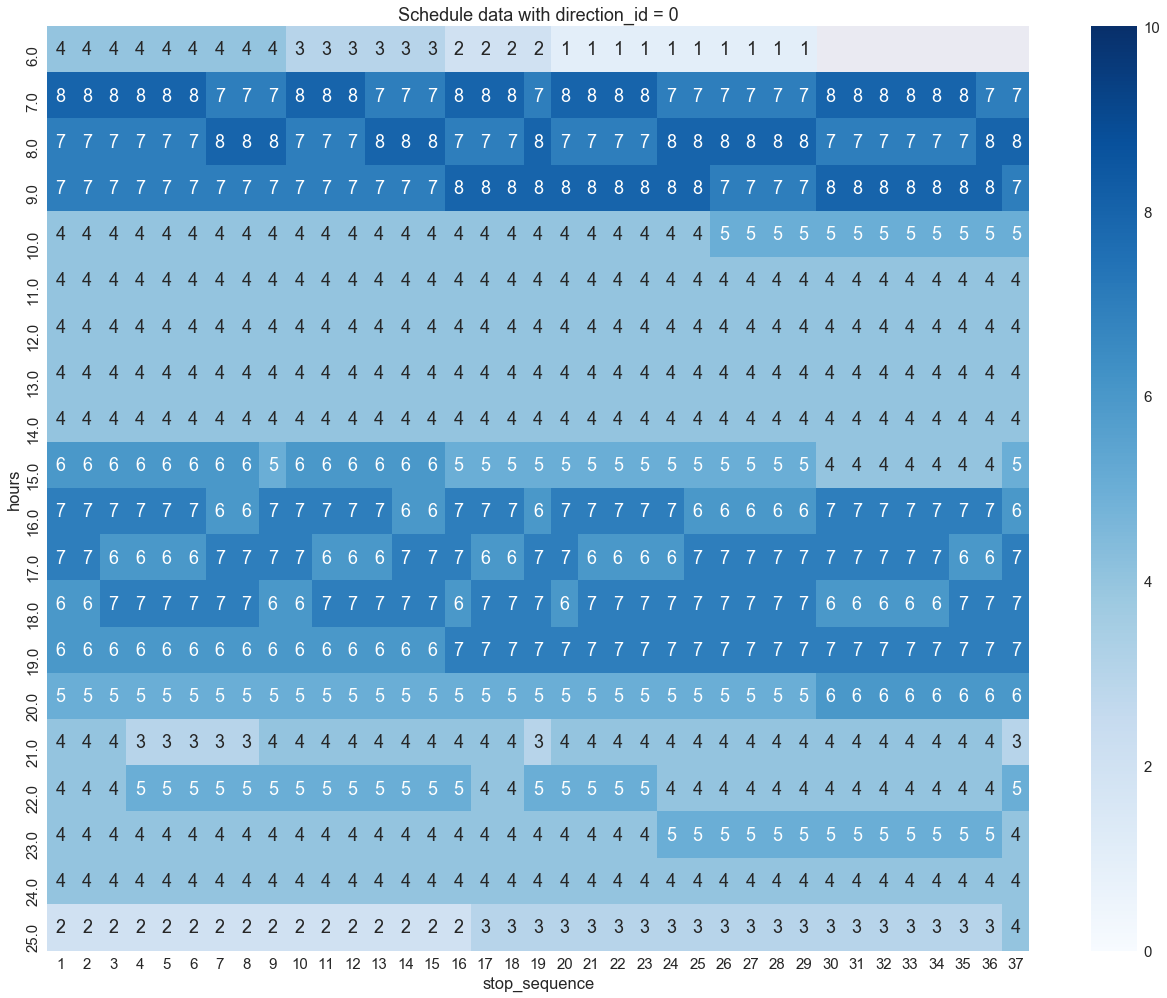

In [83]:
plt.figure(figsize = (22,17))
ax = plt.axes()
ax.set_title('Schedule data with direction_id = 0')
sns.heatmap(df2, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

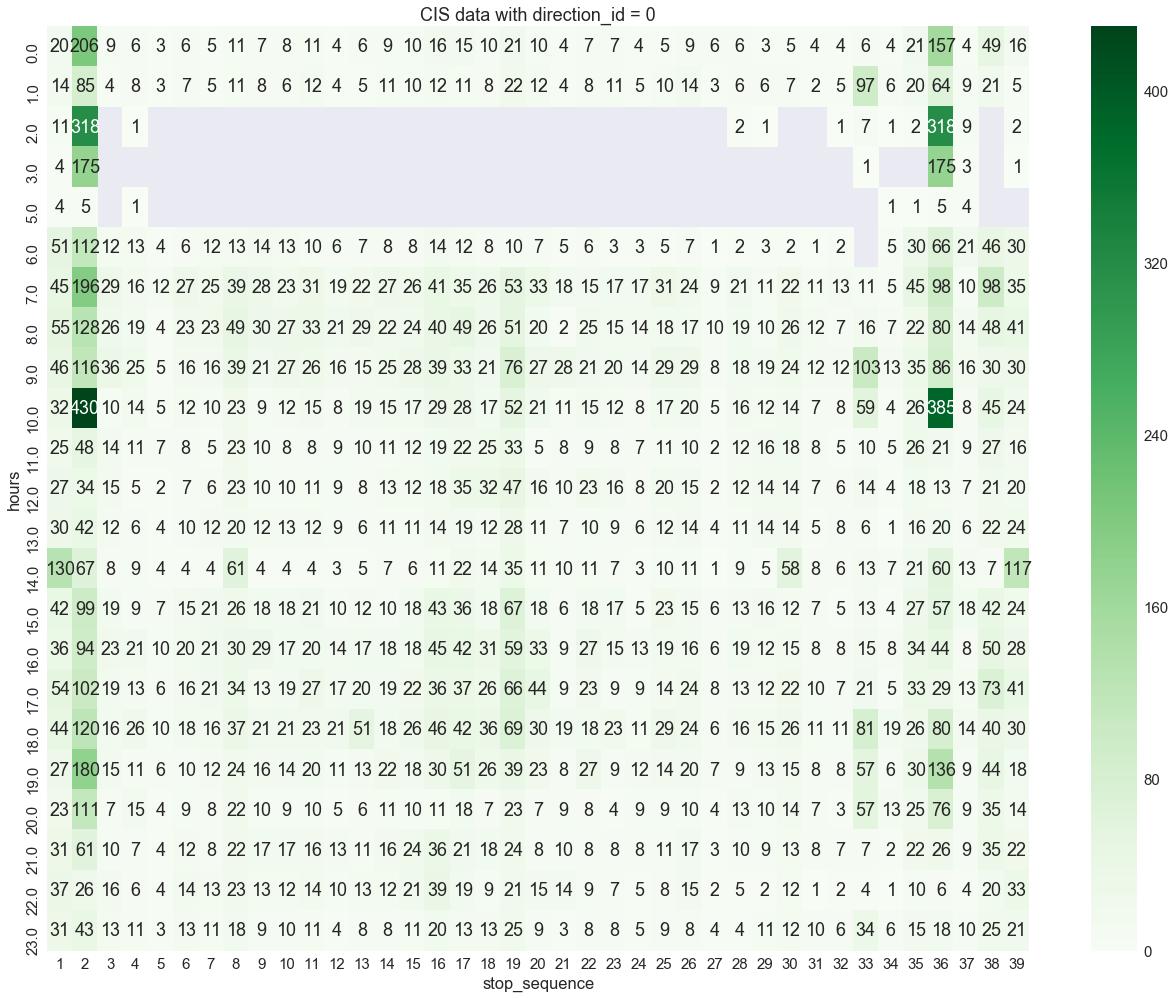

In [87]:
plt.figure(figsize = (22,17))
ax = plt.axes()
ax.set_title('CIS data with direction_id = 0')
sns.heatmap(df4, vmin=0, vmax=430,cmap = 'Greens', annot=True, fmt='g')